# Toy example

Original notebook by Alexander Held, edited for the MadMiner repository by Johann Brehmer, Irina Espejo, Felix Kling, and Kyle Cranmer 2018-2019.

In this notebook, we use a simple toy example to demonstrate the machine learning and inference algorithms in MadMiner. This allows us to skip many of the more technical steps, and there's no dependency on MadGraph, Pythia, or Delphes.

What this tutorial does not do, is explaining the inference methods. To understand what's happening, please have a look at ["Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00013), which will explain the basic idea in just a few pages. If you really want to get down to the dirty details, ["A Guide to Constraining Effective Field Theories With Machine Learning"](https://arxiv.org/abs/1805.00020) has you covered.

## Preparations

In [75]:
import os
import logging
import numpy as np
from scipy.stats import norm
from matplotlib import pyplot as plt

%matplotlib inline
import sys
sys.path.append('/remote/gpu02/crescenzo/MadMiner')

from madminer.ml import ScoreEstimator

In [76]:
if not os.path.exists("data_der_far"):
    os.makedirs("data_der_far")

MadMiner uses the Python `logging` module to provide additional information and debugging output. You can choose how much of this output you want to see by switching the level in the following lines to `logging.DEBUG` or `logging.WARNING`.

In [77]:
# MadMiner output
logging.basicConfig(
    format="%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

## 1. A toy simulator

Our simulator depends on just one parameter `theta` and produces one-dimensional observables `x`. It is characterized by one latent variable `z`. "Running" the simulator consists of two steps:
- "Hard process": a value of `z` is drawn from a normal distribution, where the mean depends on `theta`. 
- "Detector": a value for `x` is drawn from a normal distribution with mean equal to `z`. There is no explicit dependence on `theta`.

As in the particle physics case, we assume that we can calculate the joint likelihood ratio `r(x, z | theta0, theta1)` as well as the joint score `t(x, z | theta)`, which depend explicitly on `z` (and where the "detector" part cancels).

Here are some general settings (feel free to play with them): 

In [78]:
z_std = 2.0
x_std = 1.0

The following function runs the simulator for a value of `theta` and calculates the joint likelihood ratio between `theta0` and `theta1` as well as the joint score at `theta_score`:

In [79]:
alpha=10

In [80]:
npoints = 100

In [81]:
theta = 100

In [82]:
z1 = np.random.normal(loc=0, scale=z_std, size=npoints)
z2 = np.random.normal(loc=alpha, scale=z_std, size=npoints)
mask = np.random.choice([True, False],p=[1./(1+theta**2),theta**2/(1+theta**2)],size=npoints)

In [83]:
z1[mask].flatten()

array([], dtype=float64)

In [84]:
np.concatenate((z1[mask],z2[~mask]))

array([ 6.14006181, 10.00947669,  8.58306871, 11.94725206, 10.23545383,
       12.37747331,  8.5577339 , 12.08352805,  7.81245807,  8.18017233,
        9.52694907,  8.43732353, 10.18270689,  9.9039064 ,  8.1371029 ,
        9.87367227, 11.25179288, 13.50975235, 14.87066761, 10.6892306 ,
       15.09738795,  9.35305855, 15.89488078, 10.50979476, 12.16894758,
        7.4709402 , 11.37617571, 10.47473575,  8.32692986, 12.45775039,
       13.01473224,  5.28449049, 11.03821912, 10.73587242,  9.74368521,
       11.13069121,  6.43957019, 12.56841971,  9.11408867, 11.67815941,
        9.77693093,  8.7932042 , 10.49158726,  9.99303837,  8.01249724,
       14.75345692, 11.96828785, 12.81376426, 10.30732379,  8.15923464,
        8.31257185,  7.67941714, 11.87268306,  7.20104777,  9.88635149,
        9.77406253,  9.74208036, 13.24398104,  7.4358357 ,  8.15718913,
        5.8651965 , 11.49417591,  8.9311767 ,  8.87935816,  8.18164355,
       13.70004024,  9.6931507 ,  9.39436055,  8.7690437 , 11.32

In [85]:
np.random.choice([True,False],p = [0.5,0.5],size = None)

True

In [86]:
def simulate(npoints=None):
    # Draw latent variables z
    z = np.random.normal(loc=0, scale=z_std, size=npoints)
    x = np.random.normal(loc=z, scale=x_std, size=None)
    first_der = np.zeros(npoints)
    second_der = norm(loc=alpha,scale=z_std).pdf(z)/norm(loc=0,scale=z_std).pdf(z)
    shuf = np.random.permutation(z.shape[0])
    return x[shuf], first_der[shuf], second_der[shuf]

In [87]:
def simulate_2(theta, theta0=None, theta1=None, theta_score=None, npoints=None):
    # Draw latent variables z
    z1 = np.random.normal(loc=0, scale=z_std, size=npoints)
    z2 = np.random.normal(loc=alpha, scale=z_std, size=npoints)
    mask = np.random.choice([True, False],p=[1./(1+theta**2),theta**2/(1+theta**2)],size=npoints)
    try:
        z = np.concatenate((z1[mask],z2[~mask]))
    except:
        if mask:
            z = z1
        else:
            z = z2
    # Draw observables x
    x = np.random.normal(loc=z, scale=x_std, size=None)

    # Calculate joint likelihood ratio and joint score
    if theta0 is not None and theta1 is not None:
        r_xz = (norm(loc=theta1, scale=z_std).pdf(z)+(theta0**2)*norm(loc=alpha, scale=z_std).pdf(z) )/ ((1+theta0**2)*norm(loc=theta1, scale=z_std).pdf(z))
    else:
        r_xz = None

    if theta_score is not None:
        t_xz = (x - theta_score) / z_std**2
    else:
        t_xz = None

    return x, r_xz, t_xz

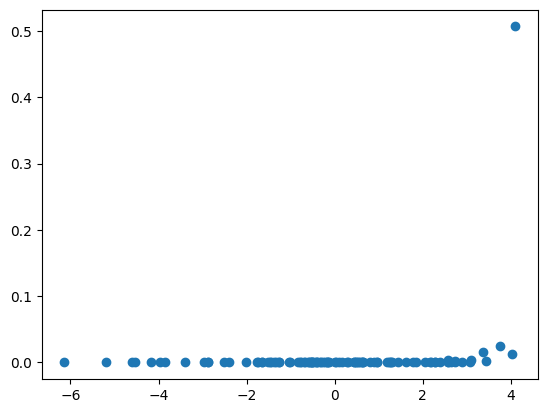

In [88]:
s = simulate(100)
plt.scatter(s[0],s[2])

Usually the likelihood function `p(x|theta)` is intractable, but in this toy example it is just given by the convolution of two Gaussians, which is again a Gaussian. We will use this to validate the results later:

In [89]:
def calculate_likelihood_ratio(x, theta0, theta1=0.0):
    combined_std = (z_std**2 + x_std**2) ** 0.5
    r_x = (norm(loc=theta1, scale=combined_std).pdf(x)+(theta0**2)*norm(loc=alpha, scale=combined_std).pdf(x) )/ ((1+theta0**2)*norm(loc=theta1, scale=combined_std).pdf(x))
    return r_x

In [90]:
x_train, first_der, second_der = simulate(100000)

In [91]:
np.save("data_der_far/x_train.npy",x_train)
np.save("data_der_far/first_der.npy",first_der)
np.save("data_der_far/second_der.npy",second_der)

In [92]:
sally = ScoreEstimator(n_hidden=(20, 20))

sally.train(
    method="sally",
    x="data_der_far/x_train.npy",
    t_xz="data_der_far/first_der.npy",
    n_epochs=20,
)

sally.save("models_der_far/sally_first")

14:47 madminer.ml.score    INFO    Starting training
14:47 madminer.ml.score    INFO      Batch size:             128
14:47 madminer.ml.score    INFO      Optimizer:              amsgrad
14:47 madminer.ml.score    INFO      Epochs:                 20
14:47 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
14:47 madminer.ml.score    INFO      Validation split:       0.25
14:47 madminer.ml.score    INFO      Early stopping:         True
14:47 madminer.ml.score    INFO      Scale inputs:           True
14:47 madminer.ml.score    INFO      Shuffle labels          False
14:47 madminer.ml.score    INFO      Samples:                all
14:47 madminer.ml.score    INFO    Loading training data
14:47 madminer.utils.vario INFO      Loading data_der_far/x_train.npy into RAM
14:47 madminer.utils.vario INFO      Loading data_der_far/first_der.npy into RAM
14:47 madminer.ml.score    INFO    Found 100000 samples with 1 parameters and 1 observables
14:47 madmine

In [93]:
sally = ScoreEstimator(n_hidden=(20, 20))

loss = sally.train(
    method="sally",
    x="data_der_far/x_train.npy",
    t_xz="data_der_far/second_der.npy",
    n_epochs=100,
)

sally.save("models_der_far/sally_second")

14:47 madminer.ml.score    INFO    Starting training
14:47 madminer.ml.score    INFO      Batch size:             128
14:47 madminer.ml.score    INFO      Optimizer:              amsgrad
14:47 madminer.ml.score    INFO      Epochs:                 100
14:47 madminer.ml.score    INFO      Learning rate:          0.001 initially, decaying to 0.0001
14:47 madminer.ml.score    INFO      Validation split:       0.25
14:47 madminer.ml.score    INFO      Early stopping:         True
14:47 madminer.ml.score    INFO      Scale inputs:           True
14:47 madminer.ml.score    INFO      Shuffle labels          False
14:47 madminer.ml.score    INFO      Samples:                all
14:47 madminer.ml.score    INFO    Loading training data
14:47 madminer.utils.vario INFO      Loading data_der_far/x_train.npy into RAM
14:47 madminer.utils.vario INFO      Loading data_der_far/second_der.npy into RAM
14:47 madminer.ml.score    INFO    Found 100000 samples with 1 parameters and 1 observables
14:47 madmi

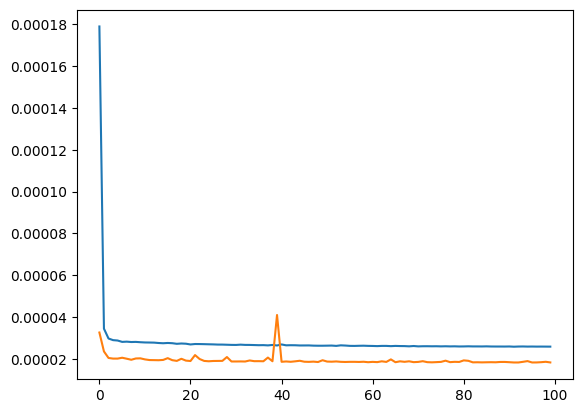

In [94]:
plt.plot(loss[0])
plt.plot(loss[1])

In [95]:
sally = ScoreEstimator(n_hidden=(20, 20))
sally.load("models_der_far/sally_second")

14:51 madminer.ml.base     INFO    Loading model from models_der_far/sally_second


In [96]:
def evaluate_der_perfect(first,second,theta):
    return (1+theta*first+theta**2*second)/((1+theta**2)*(1))
def evaluate_der_error(first,second,theta):
    return (1+theta*first+theta**2*second)/((1+theta**2)*(1+np.random.normal(0,(1+theta**2)/1000)))

In [97]:
np.max(second_der)

7943.00774445766

In [98]:
sally = ScoreEstimator(n_hidden=(20, 20))
sally.load("models_der_far/sally_first")
x_test = simulate_2(1,npoints=1000)[0]
f = sally.evaluate(x_test)*0.
sally = ScoreEstimator(n_hidden=(20, 20))
sally.load("models_der_far/sally_second")
s = (sally.evaluate(x_test)*np.sqrt(np.max(second_der)))**2

14:51 madminer.ml.base     INFO    Loading model from models_der_far/sally_first
14:51 madminer.ml.base     INFO    Loading model from models_der_far/sally_second


In [99]:
n_param_points_test = 100
th_grid = np.linspace(-4,4,n_param_points_test)
means_perfect = []
means_error = []
for t in th_grid:
    r_p = evaluate_der_perfect(f,s,t)
    mask_p = r_p>0
    r_p = r_p[mask_p]
    means_perfect.append(np.mean(-2*np.log(r_p)))
    r_e = evaluate_der_error(f,s,t)
    mask_e = r_e>0
    r_e = r_e[mask_e]
    means_error.append(np.mean(-2*np.log(r_e)))

In [100]:
all_log_r_test_true = []
nllr_test_true = []
for theta in th_grid:
    log_r = np.log(calculate_likelihood_ratio(x_test, theta))
    nllr_test_true.append(-2.0 * np.mean(log_r))
    all_log_r_test_true.append(log_r)

all_log_r_test_true = np.asarray(all_log_r_test_true).reshape((np.shape(x_test)[0], n_param_points_test))
nllr_test_true = np.asarray(nllr_test_true)

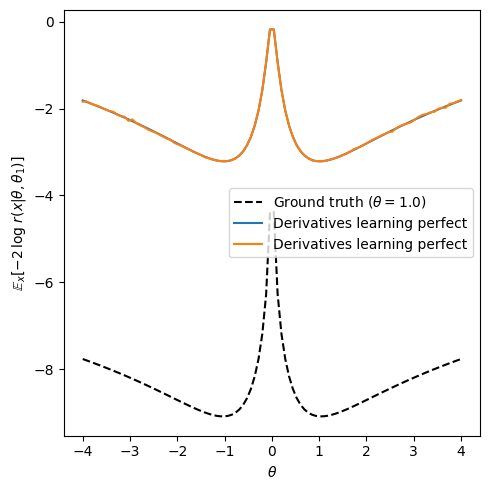

In [101]:
fig = plt.figure(figsize=(5, 5))

plt.plot(
    th_grid,
    nllr_test_true,
    ls="--",
    c="black",
    label=r"Ground truth ($\theta = 1.0$)",
)
plt.plot(
    th_grid,
    means_perfect,
    label=r"Derivatives learning perfect",
)

plt.plot(
    th_grid,
    means_error,
    label=r"Derivatives learning perfect",
)


plt.xlabel(r"$\theta$")
plt.ylabel(r"$\mathbb{E}_x [ -2\, \log \,r(x | \theta, \theta_{1}) ]$")

plt.legend()
plt.tight_layout()
plt.show()